In [1]:
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
import sys
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(parent_dir)
sys.path.append(os.path.abspath(os.path.join(parent_dir, '..')))

In [3]:
from models_mdf import CustomModel, load_model_, save_model

[2025-05-29 12:59:24,642] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d



class MyLabelEncoder(LabelEncoder):
    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self
    
    
def add_spaces(seq):
     return ' '.join(list(seq))
    

def balance_majority(genes: pd.DataFrame, colu, min_count=20, max_count=1500):
    counts = genes[colu].value_counts()
    counts = counts.drop(counts[min_count>counts].index)
    resampled = pd.DataFrame()
    maj_clss = (counts[counts>max_count]).index
    left_genes = pd.DataFrame()
    mean_clss = counts[(counts<max_count) & (min_count<counts)].index#[i for i in genes[colu] if i not in min_classes]
    for cl in mean_clss:
        #print(cl)
        left_genes = pd.concat([left_genes, genes[genes[colu]==cl]])
    for maj_cl in maj_clss:        
        resampled = pd.concat([resampled, resample(genes[genes[colu] == maj_cl], replace=False, n_samples=max_count, random_state=42)])
    return pd.concat([left_genes, resampled])

In [35]:
from sklearn.preprocessing import MinMaxScaler
from natsort import natsorted


def alphanumeric_sort(gene):
    return [int(i) if i.isdigit() else i.lower() for i in re.split(r'(\d+)', gene)]

def draw_heatmap(pred_labels, ans, l_e, n_cl = None, show=True, save_dir=None, label = "Матрица ошибок для альфа V генов"):
    pred_genes = l_e.inverse_transform(pred_labels)
    ans_genes = l_e.inverse_transform(list(ans))
    
    if not n_cl:
        classes = l_e.classes_
    else:
        classes = l_e.classes_[:n_cl]
    
    matrix = pd.DataFrame(data = 0, columns= classes, index= classes)
    for i in range(len(ans_genes)):
        matrix.loc[ans_genes[i], pred_genes[i]] += 1
    
    matrix_norm = MinMaxScaler().fit_transform(matrix.T)
    matrix_norm = pd.DataFrame(data = matrix_norm.T, columns= classes, index= classes)
    matrix_norm = matrix_norm.reindex(index=natsorted(matrix_norm.index, key=alphanumeric_sort))
    matrix_norm = matrix_norm[natsorted(matrix_norm.columns, key=alphanumeric_sort)]
    
    if show:
        plt.rcParams.update({
            'xtick.labelsize': 15,  
            'ytick.labelsize': 15})
        
        fig, ax = plt.subplots(figsize=(11,9)) 
        
        sns.heatmap(matrix_norm, cmap="Greens")
        plt.title(label)
        if save_dir is not None:
            plt.savefig(save_dir)
    return matrix_norm

def norm(dist_matr):
    
    dfmax, dfmin = np.array(dist_matr).max(), np.array(dist_matr).min()

    dist_matr_norm = (dist_matr - dfmin)/(dfmax - dfmin)

    return dist_matr_norm

In [5]:
vdjdb = pd.read_csv('../data/vdjdb_epitopes.csv')

In [6]:
vdjdb.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,antigen.epitope,mhc.class
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,FLKEKGGL,MHCI
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,FLKEKGGL,MHCI
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,FLKEKGGL,MHCI
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,FLKEKGGL,MHCI
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,FLKEKGGL,MHCI


In [7]:
vdjdb.columns


Index(['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta',
       'j.beta', 'antigen.epitope', 'mhc.class'],
      dtype='object')

In [8]:
vdjb_alpha = vdjdb[['cdr3.alpha', 'antigen.epitope']].dropna()
print(vdjb_alpha.shape)
vdjb_alpha = vdjb_alpha[vdjb_alpha['antigen.epitope'] != 'KLGGALQAK']
print(vdjb_alpha.shape)

(24075, 2)
(24075, 2)


In [10]:
le = MyLabelEncoder()
groups = vdjb_alpha['antigen.epitope'].value_counts().index

le.fit(groups)
# groups
le.transform(groups)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [11]:
vdjb_alpha['antigen.epitope'].value_counts()[vdjb_alpha['antigen.epitope'].value_counts()>400].shape[0]

15

In [12]:
vdjb_alpha['antigen.epitope']= le.transform(vdjb_alpha['antigen.epitope'])
vdjb_alpha

,cdr3.alpha,antigen.epitope
0,CIVRAPGRADMRF,210
2,CAVPSGAGSYQLTF,210
3,CAVKASGSRLT,210
4,CAYRPPGTYKYIF,210
5,CIVRAPGRADMRF,305
...,...,...
48198,CMDEGGSNYKLTF,69
48199,CSLYNNNDMRF,69
48200,CALSTDSWGKLQF,150
48201,CAPQGATNKLIF,150


In [13]:
vdjb_alpha = vdjb_alpha[vdjb_alpha['antigen.epitope']<=15]

<BarContainer object of 16 artists>

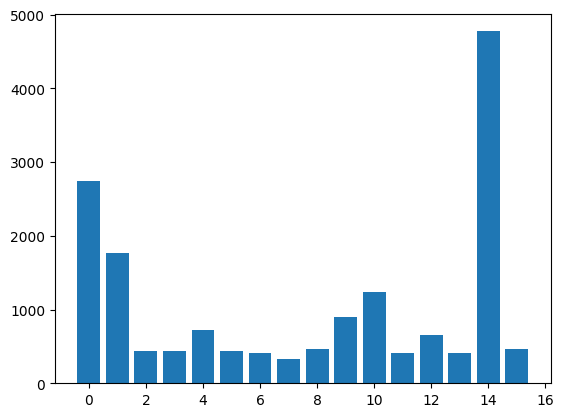

In [14]:
plt.bar(vdjb_alpha['antigen.epitope'].unique(), vdjb_alpha['antigen.epitope'].value_counts())

In [15]:
alpha_data = vdjb_alpha.reset_index(drop=True)

In [16]:
alpha_data['antigen.epitope'].value_counts()

0     4774
1     2746
2     1764
3     1235
4      894
5      729
6      661
7      470
8      460
9      437
10     436
11     431
12     417
13     410
14     405
15     333
Name: antigen.epitope, dtype: int64

In [17]:
alpha_resampl = balance_majority(alpha_data, 'antigen.epitope', max_count=1000)

In [18]:
alpha_test = alpha_resampl.sample(frac=0.15, random_state=42)
alpha_train = alpha_resampl.drop(alpha_test.index)

alpha_train

,cdr3.alpha,antigen.epitope
78,CVVNRNNDMRF,4
79,CAVNRDDKIIF,4
502,CVVNSGNDMRF,4
503,CVVNKEDKIIF,4
504,CVVNRDTDKLIF,4
...,...,...
10117,CAVTHTGGFKTIF,3
10137,CAASETSYDKVIF,3
9777,CAMREGSGYTGNQFYF,3
8737,CILRDVRGQNFVF,3


In [19]:
alpha_train['cdr3.alpha']  = alpha_train['cdr3.alpha'].apply(add_spaces)
alpha_test['cdr3.alpha']  = alpha_test['cdr3.alpha'].apply(add_spaces)

In [20]:
ans = alpha_test['antigen.epitope']
alpha_test = alpha_test.drop(columns=['antigen.epitope'])

In [21]:
N_LABELS = alpha_train['antigen.epitope'].nunique()


In [22]:
N_LABELS

16

### TCR-bert

In [23]:
epit_mod = CustomModel(n_labels=N_LABELS)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [24]:
alpha_train.reset_index(drop=True, inplace=True)

In [25]:
input_ids, attention_masks, labels = epit_mod.tokenize(alpha_train['cdr3.alpha'], alpha_train['antigen.epitope'])

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
train_dataset, val_dataset = epit_mod.split_data(input_ids, attention_masks, labels)

6,856 training samples
1,715 validation samples


In [27]:
epit_mod.fit(train_dataset, val_dataset, epochs=5)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 2.02
  Training epcoh took: 0:00:20

Running Validation...
  Accuracy: 0.41
  Validation Loss: 1.86
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.72
  Training epcoh took: 0:00:18

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.76
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...

  Average training loss: 1.56
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.45
  Validation Loss: 1.75
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...

  Average training loss: 1.42
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.45
  Validation Loss: 1.75
  Validation took: 0:00:01

======== Epoch 5 / 5 ========
Training...

  Average training loss: 1.31
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.45
  Validation Loss: 1.76
  Validation took: 0:00:01

Training complete!


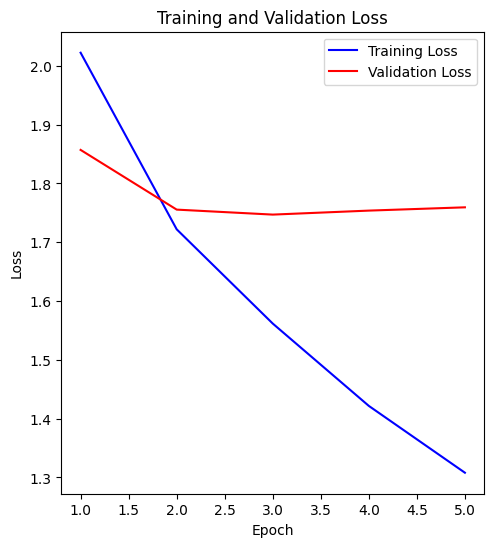

In [28]:
epit_mod.draw_stats_plot()

In [29]:
epit_mod.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.022245,1.856982,0.406443,0:00:20,0:00:01
2,1.721960,1.755460,0.441744,0:00:18,0:00:01
3,1.561682,1.746985,0.449846,0:00:17,0:00:01
4,1.421668,1.753772,0.445795,0:00:17,0:00:01
5,1.308065,1.759350,0.447531,0:00:17,0:00:01


In [31]:
alpha_test

,cdr3.alpha
1594,C A G L K T D S W G K L Q F
531,C V V N M N N N D M R F
16516,C A G M N Y G G S Q G N L I F
14481,C A M D P L T G G G N K L T F
12241,C A A S G G Y Q N F Y F
...,...
351,C A M S R G N F G N E K L T F
4236,C A P N T G T A S K L T F
387,C A V S T G A N N L F F
4873,C A G S Y G G S Q G N L I F


In [33]:
pred_labels = epit_mod.predict(alpha_test['cdr3.alpha'])
f1_sc = f1_score(ans, pred_labels, average='weighted')
print('Total f1_score: %.5f' % f1_sc)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.47739


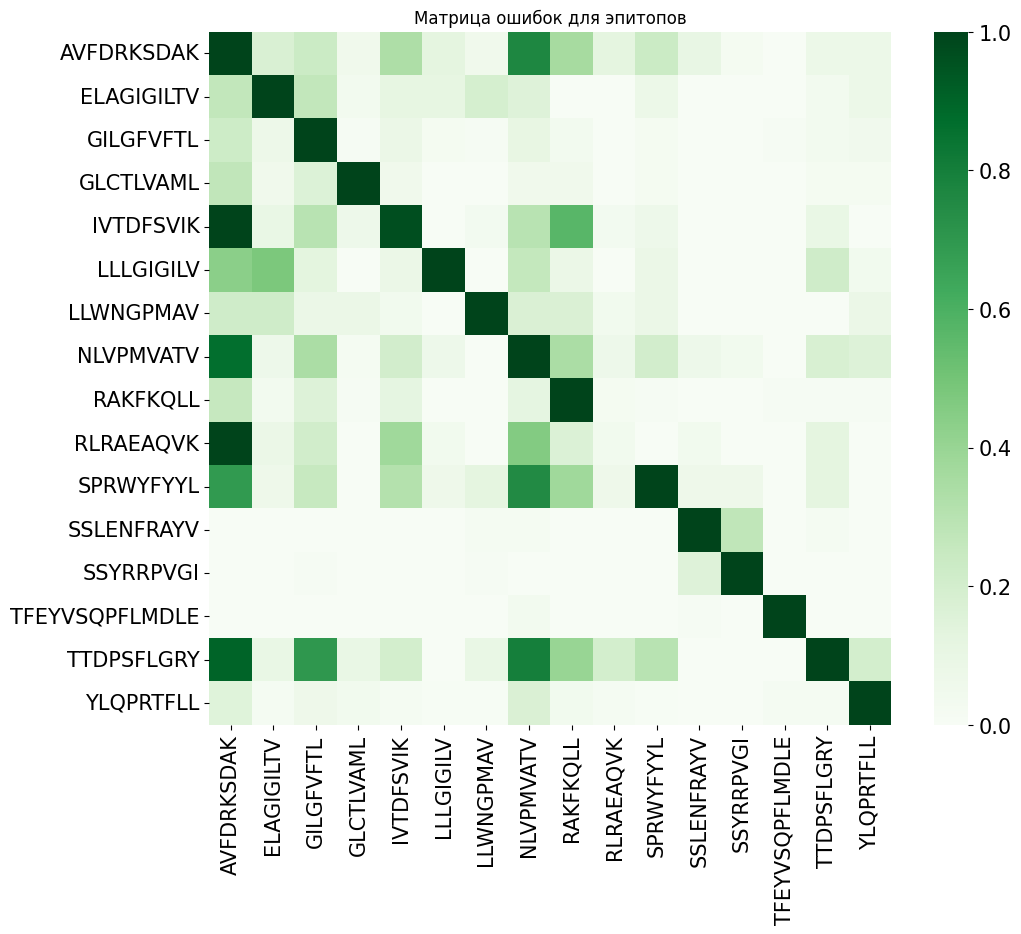

In [36]:
notm_matrix_epit = draw_heatmap(pred_labels, ans.values, le, n_cl=N_LABELS, label='Матрица ошибок для эпитопов')


In [38]:
save_model(epit_mod, 'models_ft/alpha_tct.pth')

## Beta 

In [39]:
vdjb_beta = vdjdb[['cdr3.beta', 'antigen.epitope']].dropna()
print(vdjb_beta.shape)
vdjb_beta = vdjb_beta[vdjb_beta['antigen.epitope'] != 'KLGGALQAK']
print(vdjb_beta.shape)

(40748, 2)
(40748, 2)


In [40]:
le_beta = MyLabelEncoder()
groups_beta = vdjb_beta['antigen.epitope'].value_counts().index

le_beta.fit(groups_beta)
# groups
le_beta.transform(groups_beta)

array([   0,    1,    2, ..., 1164, 1165, 1166])

In [41]:
vdjb_beta['antigen.epitope'].value_counts()[vdjb_beta['antigen.epitope'].value_counts()>450].shape[0]

16

In [42]:
vdjb_beta['antigen.epitope']= le_beta.transform(vdjb_beta['antigen.epitope'])
vdjb_beta

,cdr3.beta,antigen.epitope
0,CASSYLPGQGDHYSNQPQHF,33
1,CASSFEAGQGFFSNQPQHF,33
2,CASSFEPGQGFYSNQPQHF,33
3,CASSYEPGQVSHYSNQPQHF,33
4,CASSALASLNEQFF,33
...,...,...
48198,CASSVRSTDTQYF,128
48199,CASSLRYTDTQYF,128
48200,CASSPGQGGDNEQFF,239
48201,CASSLGAGGQETQYF,239


In [43]:
vdjb_beta = vdjb_beta[vdjb_beta['antigen.epitope']<16]

<BarContainer object of 16 artists>

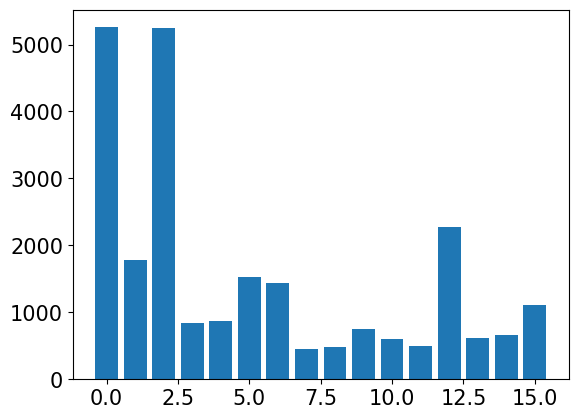

In [44]:
plt.bar(vdjb_beta['antigen.epitope'].unique(), vdjb_beta['antigen.epitope'].value_counts())

In [45]:
beta_data = vdjb_beta.reset_index(drop=True)

In [46]:
beta_data['antigen.epitope'].value_counts()

0     5258
1     5250
2     2282
3     1782
4     1521
5     1443
6     1114
7      873
8      847
9      757
10     661
11     610
12     595
13     495
14     477
15     456
Name: antigen.epitope, dtype: int64

In [47]:
beta_resampl = balance_majority(beta_data, 'antigen.epitope', max_count=1000)

In [48]:
beta_test = beta_resampl.sample(frac=0.15, random_state=42)
beta_train = beta_resampl.drop(beta_test.index)

beta_train

,cdr3.beta,antigen.epitope
21451,CASSQERTSNTEAFF,7
21452,CASSLNRLEKETQYF,7
21453,CASSLDRISNQPQYF,7
21454,CASSQDRPGLANTEAFF,7
21455,CASREFGNLNQPQYF,7
...,...,...
22837,CASSLDIEAFF,6
23419,CASSDLNTGELFF,6
22939,CASSDLSTGELFF,6
23243,CATQAVNTGELFF,6


In [49]:
beta_train['cdr3.beta']  = beta_train['cdr3.beta'].apply(add_spaces)
beta_test['cdr3.beta']  = beta_test['cdr3.beta'].apply(add_spaces)

In [50]:
ans = beta_test['antigen.epitope']
beta_test = beta_test.drop(columns=['antigen.epitope'])

In [51]:
N_LABELS_beta = beta_train['antigen.epitope'].nunique()


In [52]:
N_LABELS_beta

16

### TCR-bert

In [53]:
epit_mod_beta = CustomModel(n_labels=N_LABELS_beta)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [54]:
beta_train.reset_index(drop=True, inplace=True)

In [55]:
input_ids, attention_masks, labels = epit_mod_beta.tokenize(beta_train['cdr3.beta'], beta_train['antigen.epitope'])

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [56]:
train_dataset, val_dataset = epit_mod_beta.split_data(input_ids, attention_masks, labels)

8,684 training samples
2,171 validation samples


In [57]:
epit_mod_beta.fit(train_dataset, val_dataset, epochs=5)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.89
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.46
  Validation Loss: 1.67
  Validation took: 0:00:02

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.52
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.58
  Validation took: 0:00:02

======== Epoch 3 / 5 ========
Training...

  Average training loss: 1.33
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.52
  Validation Loss: 1.56
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...

  Average training loss: 1.15
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.53
  Validation Loss: 1.54
  Validation took: 0:00:02

======== Epoch 5 / 5 ========
Training...

  Average training loss: 1.01
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.53
  Validation Loss: 1.55
  Validation took: 0:00:02

Training complete!


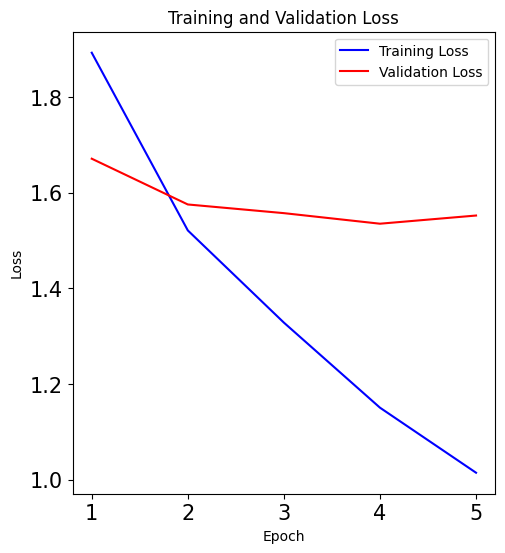

In [58]:
epit_mod_beta.draw_stats_plot()

In [59]:
epit_mod_beta.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.892970,1.671288,0.459183,0:00:25,0:00:02
2,1.521249,1.575555,0.495948,0:00:25,0:00:02
3,1.328417,1.557406,0.519845,0:00:25,0:00:01
4,1.150500,1.535316,0.527448,0:00:25,0:00:02
5,1.014434,1.552415,0.527448,0:00:25,0:00:02


In [63]:
epit_mod_beta = load_model_('models_ft/beta_tcr_bert_epit_model.pth', mod_type='TCR-bert', num_labels=N_LABELS_beta)
epit_mod_beta.maximun_len = 40
epit_mod_beta.to(device)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [65]:
beta_test

,cdr3.beta
20741,C A S S T D Y V E Q Y F
9735,C A S S L D T D T Q Y F
9067,C A S S L L V S G N E Q F F
11534,C A S S E G A G G F G Q P Q H F
20000,C A S R G R Q G R W S S G A N V L T F
...,...
19908,C A S S P G Q F S H E Q Y F
17210,C A S S P G S T E A F F
17250,C A S S T P G Q G A G E Q F F
23406,C A S S L G Q R S T E A F F


In [67]:
pred_labels = epit_mod_beta.predict(beta_test['cdr3.beta'])
f1_sc = f1_score(ans, pred_labels, average='weighted')
print('Total f1_score: %.5f' % f1_sc)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.51961


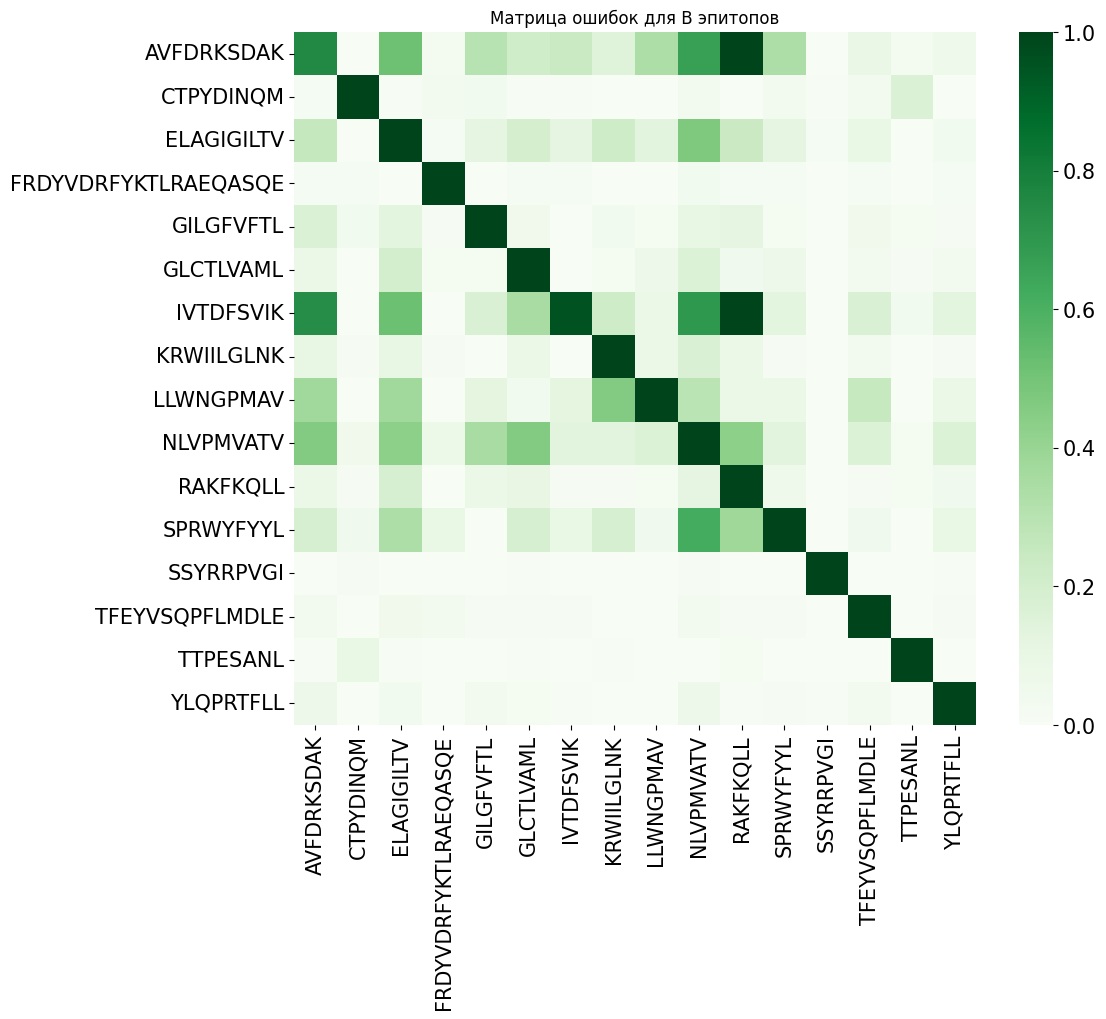

In [69]:
notm_matrix_epit = draw_heatmap(pred_labels, ans.values, le_beta, n_cl=N_LABELS_beta, label='Матрица ошибок для B эпитопов')


In [62]:
save_model(epit_mod_beta, 'models_ft/beta_tcr_bert_epit_model.pth')